- 플래너의 처리가 매우 복잡하기 때문에 이 절에서는 가장 간단한 프로세스, 즉 단일 테이블 쿼리의 계획 트리가 생성되는 방법을 설명

- PostgreSQL의 플래너는 아래와 같이 세 단계를 수행.
  - 전처리를 수행합니다.
  - 가능한 모든 액세스 경로의 비용을 추정하여 가장 저렴한 액세스 경로를 얻음.
  - 가장 저렴한 경로에서 계획 트리를 만듭니다.

- 접근 경로는 비용을 추정하기 위한 처리 단위.
- 예를 들어 순차 스캔, 인덱스 스캔, 정렬 및 다양한 조인 작업에는 해당 경로가 있습니다.
- 액세스 경로는 계획 트리를 생성하기 위해 플래너 내부에서만 사용.

- 액세스 경로의 가장 기본적인 데이터 구조는 pathnodes.hPath 에 정의된 구조 이며 순차 스캔에 해당.
-  다른 모든 액세스 경로는 이를 기반으로 함.

**path**


```
typedef struct PathKey
{
	pg_node_attr(no_read, no_query_jumble)
	NodeTag		type;

	/* the value that is ordered */
	EquivalenceClass *pk_eclass pg_node_attr(copy_as_scalar, equal_as_scalar);
	Oid		pk_opfamily;	/* btree opfamily defining the ordering */
	int		pk_strategy;	/* sort direction (ASC or DESC) */
	bool		pk_nulls_first; /* do NULLs come before normal values? */
} PathKey;

typedef struct Path
{
	pg_node_attr(no_copy_equal, no_read, no_query_jumble)

	NodeTag		type;

	/* tag identifying scan/join method */
	NodeTag		pathtype;

	/*
	 * the relation this path can build
	 *
	 * We do NOT print the parent, else we'd be in infinite recursion.  We can
	 * print the parent's relids for identification purposes, though.
	 */
	RelOptInfo *parent pg_node_attr(write_only_relids);

	/*
	 * list of Vars/Exprs, cost, width
	 *
	 * We print the pathtarget only if it's not the default one for the rel.
	 */
	PathTarget *pathtarget pg_node_attr(write_only_nondefault_pathtarget);

	/*
	 * parameterization info, or NULL if none
	 *
	 * We do not print the whole of param_info, since it's printed via
	 * RelOptInfo; it's sufficient and less cluttering to print just the
	 * required outer relids.
	 */
	ParamPathInfo *param_info pg_node_attr(write_only_req_outer);

	/* engage parallel-aware logic? */
	bool		parallel_aware;
	/* OK to use as part of parallel plan? */
	bool		parallel_safe;
	/* desired # of workers; 0 = not parallel */
	int			parallel_workers;

	/* estimated size/costs for path (see costsize.c for more info) */
	Cardinality rows;			/* estimated number of result tuples */
	Cost		startup_cost;	/* cost expended before fetching any tuples */
	Cost		total_cost;		/* total cost (assuming all tuples fetched) */

	/* sort ordering of path's output; a List of PathKey nodes; see above */
	List	   *pathkeys;
} Path;
```

- 위의 단계를 처리하기 위해 플래너는 내부적으로PlannerInfo구조를 가지며 쿼리 트리, 쿼리에 포함된 관계에 대한 정보, 액세스 경로 등을 보유.

**PlannerInfo**

```
/*----------
 * PlannerInfo
 *		Per-query information for planning/optimization
 *
 * This struct is conventionally called "root" in all the planner routines.
 * It holds links to all of the planner's working state, in addition to the
 * original Query.  Note that at present the planner extensively modifies
 * the passed-in Query data structure; someday that should stop.
 *
 * For reasons explained in optimizer/optimizer.h, we define the typedef
 * either here or in that header, whichever is read first.
 *
 * Not all fields are printed.  (In some cases, there is no print support for
 * the field type; in others, doing so would lead to infinite recursion or
 * bloat dump output more than seems useful.)
 *----------
 */
#ifndef HAVE_PLANNERINFO_TYPEDEF
typedef struct PlannerInfo PlannerInfo;
#define HAVE_PLANNERINFO_TYPEDEF 1
#endif

struct PlannerInfo
{
	pg_node_attr(no_copy_equal, no_read, no_query_jumble)

	NodeTag		type;

	/* the Query being planned */
	Query	   *parse;

	/* global info for current planner run */
	PlannerGlobal *glob;

	/* 1 at the outermost Query */
	Index		query_level;

	/* NULL at outermost Query */
	PlannerInfo *parent_root pg_node_attr(read_write_ignore);

	/*
	 * plan_params contains the expressions that this query level needs to
	 * make available to a lower query level that is currently being planned.
	 * outer_params contains the paramIds of PARAM_EXEC Params that outer
	 * query levels will make available to this query level.
	 */
	/* list of PlannerParamItems, see below */
	List	   *plan_params;
	Bitmapset  *outer_params;

	/*
	 * simple_rel_array holds pointers to "base rels" and "other rels" (see
	 * comments for RelOptInfo for more info).  It is indexed by rangetable
	 * index (so entry 0 is always wasted).  Entries can be NULL when an RTE
	 * does not correspond to a base relation, such as a join RTE or an
	 * unreferenced view RTE; or if the RelOptInfo hasn't been made yet.
	 */
	struct RelOptInfo **simple_rel_array pg_node_attr(array_size(simple_rel_array_size));
	/* allocated size of array */
	int			simple_rel_array_size;

	/*
	 * simple_rte_array is the same length as simple_rel_array and holds
	 * pointers to the associated rangetable entries.  Using this is a shade
	 * faster than using rt_fetch(), mostly due to fewer indirections.  (Not
	 * printed because it'd be redundant with parse->rtable.)
	 */
	RangeTblEntry **simple_rte_array pg_node_attr(read_write_ignore);

	/*
	 * append_rel_array is the same length as the above arrays, and holds
	 * pointers to the corresponding AppendRelInfo entry indexed by
	 * child_relid, or NULL if the rel is not an appendrel child.  The array
	 * itself is not allocated if append_rel_list is empty.  (Not printed
	 * because it'd be redundant with append_rel_list.)
	 */
	struct AppendRelInfo **append_rel_array pg_node_attr(read_write_ignore);

	/*
	 * all_baserels is a Relids set of all base relids (but not joins or
	 * "other" rels) in the query.  This is computed in deconstruct_jointree.
	 */
	Relids		all_baserels;

	/*
	 * outer_join_rels is a Relids set of all outer-join relids in the query.
	 * This is computed in deconstruct_jointree.
	 */
	Relids		outer_join_rels;

	/*
	 * all_query_rels is a Relids set of all base relids and outer join relids
	 * (but not "other" relids) in the query.  This is the Relids identifier
	 * of the final join we need to form.  This is computed in
	 * deconstruct_jointree.
	 */
	Relids		all_query_rels;

	/*
	 * join_rel_list is a list of all join-relation RelOptInfos we have
	 * considered in this planning run.  For small problems we just scan the
	 * list to do lookups, but when there are many join relations we build a
	 * hash table for faster lookups.  The hash table is present and valid
	 * when join_rel_hash is not NULL.  Note that we still maintain the list
	 * even when using the hash table for lookups; this simplifies life for
	 * GEQO.
	 */
	List	   *join_rel_list;
	struct HTAB *join_rel_hash pg_node_attr(read_write_ignore);

	/*
	 * When doing a dynamic-programming-style join search, join_rel_level[k]
	 * is a list of all join-relation RelOptInfos of level k, and
	 * join_cur_level is the current level.  New join-relation RelOptInfos are
	 * automatically added to the join_rel_level[join_cur_level] list.
	 * join_rel_level is NULL if not in use.
	 *
	 * Note: we've already printed all baserel and joinrel RelOptInfos above,
	 * so we don't dump join_rel_level or other lists of RelOptInfos.
	 */
	/* lists of join-relation RelOptInfos */
	List	  **join_rel_level pg_node_attr(read_write_ignore);
	/* index of list being extended */
	int			join_cur_level;

	/* init SubPlans for query */
	List	   *init_plans;

	/*
	 * per-CTE-item list of subplan IDs (or -1 if no subplan was made for that
	 * CTE)
	 */
	List	   *cte_plan_ids;

	/* List of Lists of Params for MULTIEXPR subquery outputs */
	List	   *multiexpr_params;

	/* list of JoinDomains used in the query (higher ones first) */
	List	   *join_domains;

	/* list of active EquivalenceClasses */
	List	   *eq_classes;

	/* set true once ECs are canonical */
	bool		ec_merging_done;

	/* list of "canonical" PathKeys */
	List	   *canon_pathkeys;

	/*
	 * list of OuterJoinClauseInfos for mergejoinable outer join clauses
	 * w/nonnullable var on left
	 */
	List	   *left_join_clauses;

	/*
	 * list of OuterJoinClauseInfos for mergejoinable outer join clauses
	 * w/nonnullable var on right
	 */
	List	   *right_join_clauses;

	/*
	 * list of OuterJoinClauseInfos for mergejoinable full join clauses
	 */
	List	   *full_join_clauses;

	/* list of SpecialJoinInfos */
	List	   *join_info_list;

	/* counter for assigning RestrictInfo serial numbers */
	int			last_rinfo_serial;

	/*
	 * all_result_relids is empty for SELECT, otherwise it contains at least
	 * parse->resultRelation.  For UPDATE/DELETE/MERGE across an inheritance
	 * or partitioning tree, the result rel's child relids are added.  When
	 * using multi-level partitioning, intermediate partitioned rels are
	 * included. leaf_result_relids is similar except that only actual result
	 * tables, not partitioned tables, are included in it.
	 */
	/* set of all result relids */
	Relids		all_result_relids;
	/* set of all leaf relids */
	Relids		leaf_result_relids;

	/*
	 * list of AppendRelInfos
	 *
	 * Note: for AppendRelInfos describing partitions of a partitioned table,
	 * we guarantee that partitions that come earlier in the partitioned
	 * table's PartitionDesc will appear earlier in append_rel_list.
	 */
	List	   *append_rel_list;

	/* list of RowIdentityVarInfos */
	List	   *row_identity_vars;

	/* list of PlanRowMarks */
	List	   *rowMarks;

	/* list of PlaceHolderInfos */
	List	   *placeholder_list;

	/* array of PlaceHolderInfos indexed by phid */
	struct PlaceHolderInfo **placeholder_array pg_node_attr(read_write_ignore, array_size(placeholder_array_size));
	/* allocated size of array */
	int			placeholder_array_size pg_node_attr(read_write_ignore);

	/* list of ForeignKeyOptInfos */
	List	   *fkey_list;

	/* desired pathkeys for query_planner() */
	List	   *query_pathkeys;

	/* groupClause pathkeys, if any */
	List	   *group_pathkeys;

	/*
	 * The number of elements in the group_pathkeys list which belong to the
	 * GROUP BY clause.  Additional ones belong to ORDER BY / DISTINCT
	 * aggregates.
	 */
	int			num_groupby_pathkeys;

	/* pathkeys of bottom window, if any */
	List	   *window_pathkeys;
	/* distinctClause pathkeys, if any */
	List	   *distinct_pathkeys;
	/* sortClause pathkeys, if any */
	List	   *sort_pathkeys;

	/* Canonicalised partition schemes used in the query. */
	List	   *part_schemes pg_node_attr(read_write_ignore);

	/* RelOptInfos we are now trying to join */
	List	   *initial_rels pg_node_attr(read_write_ignore);

	/*
	 * Upper-rel RelOptInfos. Use fetch_upper_rel() to get any particular
	 * upper rel.
	 */
	List	   *upper_rels[UPPERREL_FINAL + 1] pg_node_attr(read_write_ignore);

	/* Result tlists chosen by grouping_planner for upper-stage processing */
	struct PathTarget *upper_targets[UPPERREL_FINAL + 1] pg_node_attr(read_write_ignore);

	/*
	 * The fully-processed groupClause is kept here.  It differs from
	 * parse->groupClause in that we remove any items that we can prove
	 * redundant, so that only the columns named here actually need to be
	 * compared to determine grouping.  Note that it's possible for *all* the
	 * items to be proven redundant, implying that there is only one group
	 * containing all the query's rows.  Hence, if you want to check whether
	 * GROUP BY was specified, test for nonempty parse->groupClause, not for
	 * nonempty processed_groupClause.
	 *
	 * Currently, when grouping sets are specified we do not attempt to
	 * optimize the groupClause, so that processed_groupClause will be
	 * identical to parse->groupClause.
	 */
	List	   *processed_groupClause;

	/*
	 * The fully-processed distinctClause is kept here.  It differs from
	 * parse->distinctClause in that we remove any items that we can prove
	 * redundant, so that only the columns named here actually need to be
	 * compared to determine uniqueness.  Note that it's possible for *all*
	 * the items to be proven redundant, implying that there should be only
	 * one output row.  Hence, if you want to check whether DISTINCT was
	 * specified, test for nonempty parse->distinctClause, not for nonempty
	 * processed_distinctClause.
	 */
	List	   *processed_distinctClause;

	/*
	 * The fully-processed targetlist is kept here.  It differs from
	 * parse->targetList in that (for INSERT) it's been reordered to match the
	 * target table, and defaults have been filled in.  Also, additional
	 * resjunk targets may be present.  preprocess_targetlist() does most of
	 * that work, but note that more resjunk targets can get added during
	 * appendrel expansion.  (Hence, upper_targets mustn't get set up till
	 * after that.)
	 */
	List	   *processed_tlist;

	/*
	 * For UPDATE, this list contains the target table's attribute numbers to
	 * which the first N entries of processed_tlist are to be assigned.  (Any
	 * additional entries in processed_tlist must be resjunk.)  DO NOT use the
	 * resnos in processed_tlist to identify the UPDATE target columns.
	 */
	List	   *update_colnos;

	/*
	 * Fields filled during create_plan() for use in setrefs.c
	 */
	/* for GroupingFunc fixup (can't print: array length not known here) */
	AttrNumber *grouping_map pg_node_attr(read_write_ignore);
	/* List of MinMaxAggInfos */
	List	   *minmax_aggs;

	/* context holding PlannerInfo */
	MemoryContext planner_cxt pg_node_attr(read_write_ignore);

	/* # of pages in all non-dummy tables of query */
	Cardinality total_table_pages;

	/* tuple_fraction passed to query_planner */
	Selectivity tuple_fraction;
	/* limit_tuples passed to query_planner */
	Cardinality limit_tuples;

	/*
	 * Minimum security_level for quals. Note: qual_security_level is zero if
	 * there are no securityQuals.
	 */
	Index		qual_security_level;

	/* true if any RTEs are RTE_JOIN kind */
	bool		hasJoinRTEs;
	/* true if any RTEs are marked LATERAL */
	bool		hasLateralRTEs;
	/* true if havingQual was non-null */
	bool		hasHavingQual;
	/* true if any RestrictInfo has pseudoconstant = true */
	bool		hasPseudoConstantQuals;
	/* true if we've made any of those */
	bool		hasAlternativeSubPlans;
	/* true once we're no longer allowed to add PlaceHolderInfos */
	bool		placeholdersFrozen;
	/* true if planning a recursive WITH item */
	bool		hasRecursion;

	/*
	 * Information about aggregates. Filled by preprocess_aggrefs().
	 */
	/* AggInfo structs */
	List	   *agginfos;
	/* AggTransInfo structs */
	List	   *aggtransinfos;
	/* number of aggs with DISTINCT/ORDER BY/WITHIN GROUP */
	int			numOrderedAggs;
	/* does any agg not support partial mode? */
	bool		hasNonPartialAggs;
	/* is any partial agg non-serializable? */
	bool		hasNonSerialAggs;

	/*
	 * These fields are used only when hasRecursion is true:
	 */
	/* PARAM_EXEC ID for the work table */
	int			wt_param_id;
	/* a path for non-recursive term */
	struct Path *non_recursive_path;

	/*
	 * These fields are workspace for createplan.c
	 */
	/* outer rels above current node */
	Relids		curOuterRels;
	/* not-yet-assigned NestLoopParams */
	List	   *curOuterParams;

	/*
	 * These fields are workspace for setrefs.c.  Each is an array
	 * corresponding to glob->subplans.  (We could probably teach
	 * gen_node_support.pl how to determine the array length, but it doesn't
	 * seem worth the trouble, so just mark them read_write_ignore.)
	 */
	bool	   *isAltSubplan pg_node_attr(read_write_ignore);
	bool	   *isUsedSubplan pg_node_attr(read_write_ignore);

	/* optional private data for join_search_hook, e.g., GEQO */
	void	   *join_search_private pg_node_attr(read_write_ignore);

	/* Does this query modify any partition key columns? */
	bool		partColsUpdated;
};
```

- 특정 예를 사용하여 쿼리 트리에서 계획 트리를 만드는 방법을 설명.

# **Preprocessing**

- 계획 트리를 만들기 전에 플래너는 PlannerInfo 구조에 저장된 쿼리 트리의 일부 전처리를 수행.

- 전처리에는 여러 단계가 포함되지만 이 하위 섹션에서는 단일 테이블 쿼리에 대한 주요 전처리에 대해서만 설명

- 전처리 단계에는 다음이 포함.
  - 대상 목록, 제한 조항 등을 단순화.
    - 예를 들어, Clauses.c 에 정의된 eval_const_expressions() 함수는 '2 + 2'를 '4'로 다시 씀.
  - 부울 표현식을 정규화.
    - 예를 들어, 'NOT(NOT a)'는 'a'로 다시 작성됩니다.
  - AND/OR 표현식을 평면화.
    - SQL 표준의 AND 및 OR은 이진 연산자이지만 PostgreSQL 내부에서는 n항 연산자이며 플래너는 항상 모든 중첩된 AND 및 OR 표현식이 평면화된다고 가정.
    - 구체적인 예. 부울 표현식 '(id = 1) OR (id = 2) OR (id = 3)'을 가정. 그림은 이항 연산자를 사용할 때 쿼리 트리의 일부를 보여줌. 플래너는 삼항 연산자를 사용하여 평면화하여 이 트리를 단순화.


**AND/OR 표현식을 평면화하는 예**

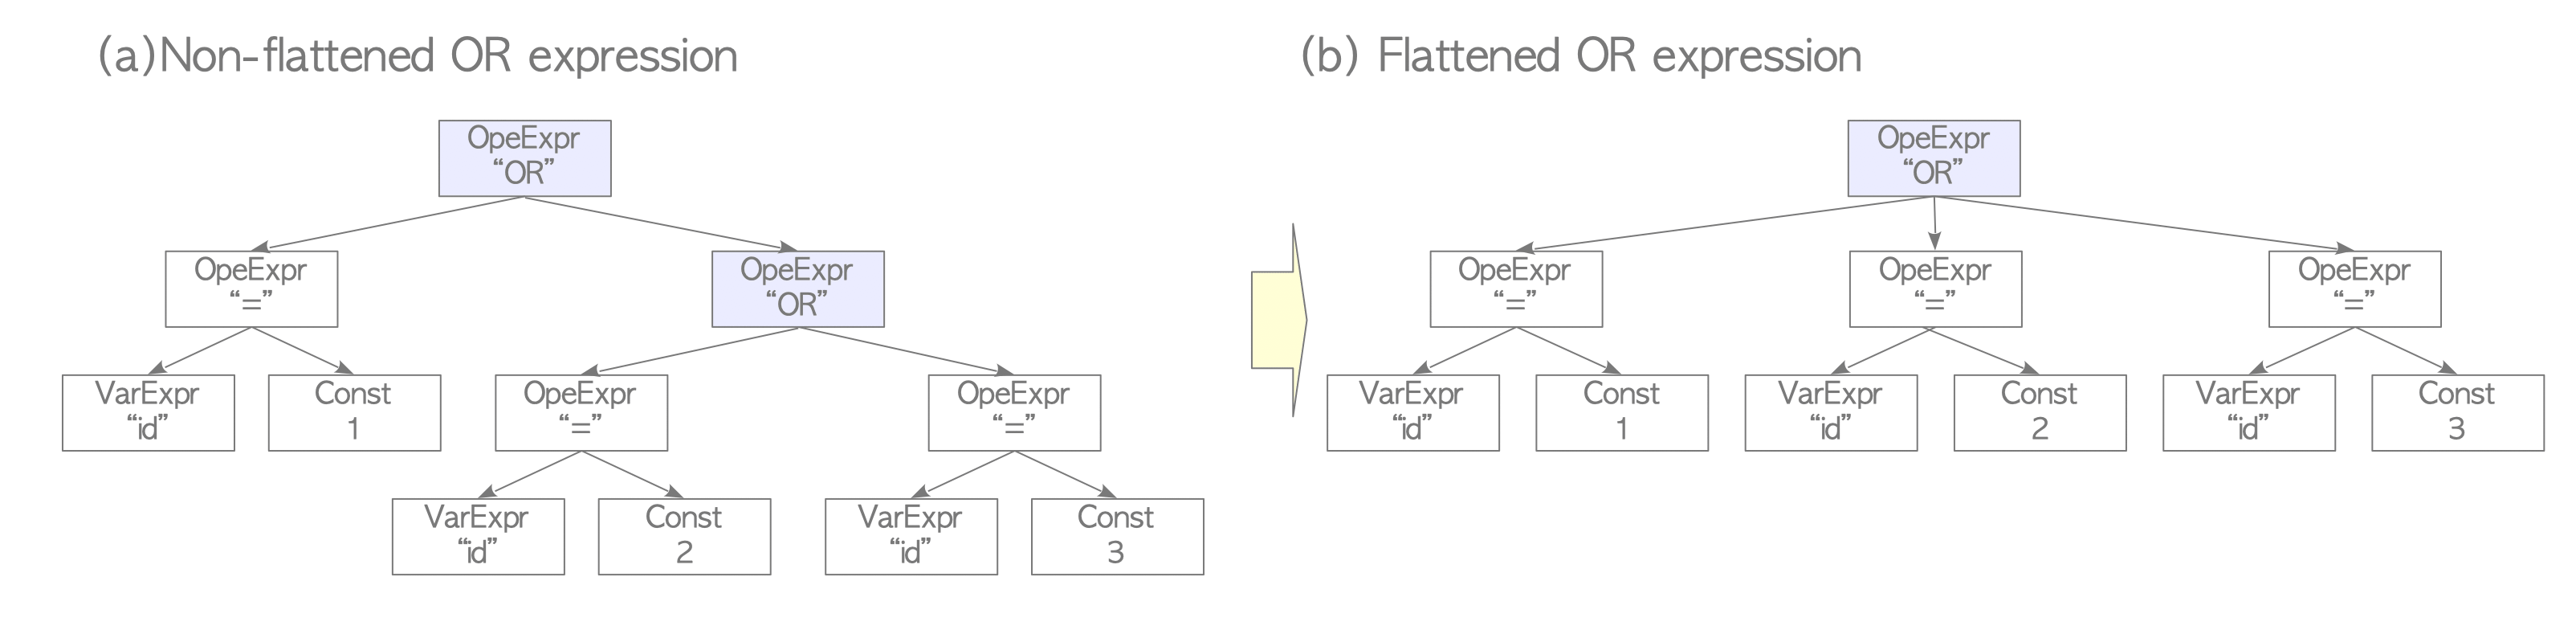

# **Getting the Cheapest Access Path**

- 가장 저렴한 액세스 경로를 얻기 위해 계획자는 가능한 모든 액세스 경로의 비용을 추정하고 가장 저렴한 경로를 선택.
- 보다 구체적으로 플래너는 다음 작업을 수행.

1. 액세스 경로와 해당 비용을 저장하는 RelOptInfo 구조를 만듬
  - RelOptInfo 구조는 make_one_rel() 함수에 의해 생성되며 PlannerInfo 구조의 simple_rel_array 에 저장
  - 초기 상태에서 RelOptInfo는 관련 인덱스가 있는 경우 baserestrictinfo 및 indexlist를 보유
  - baserestrictinfo는 쿼리의 WHERE 절을 저장하고, indexlist는 대상 테이블의 관련 인덱스를 저장.

**RelOptInfo**



```
typedef enum RelOptKind
{
	RELOPT_BASEREL,
	RELOPT_JOINREL,
	RELOPT_OTHER_MEMBER_REL,
	RELOPT_OTHER_JOINREL,
	RELOPT_UPPER_REL,
	RELOPT_OTHER_UPPER_REL
} RelOptKind;

/*
 * Is the given relation a simple relation i.e a base or "other" member
 * relation?
 */
#define IS_SIMPLE_REL(rel) \
	((rel)->reloptkind == RELOPT_BASEREL || \
	 (rel)->reloptkind == RELOPT_OTHER_MEMBER_REL)

/* Is the given relation a join relation? */
#define IS_JOIN_REL(rel)	\
	((rel)->reloptkind == RELOPT_JOINREL || \
	 (rel)->reloptkind == RELOPT_OTHER_JOINREL)

/* Is the given relation an upper relation? */
#define IS_UPPER_REL(rel)	\
	((rel)->reloptkind == RELOPT_UPPER_REL || \
	 (rel)->reloptkind == RELOPT_OTHER_UPPER_REL)

/* Is the given relation an "other" relation? */
#define IS_OTHER_REL(rel) \
	((rel)->reloptkind == RELOPT_OTHER_MEMBER_REL || \
	 (rel)->reloptkind == RELOPT_OTHER_JOINREL || \
	 (rel)->reloptkind == RELOPT_OTHER_UPPER_REL)

typedef struct RelOptInfo
{
	pg_node_attr(no_copy_equal, no_read, no_query_jumble)

	NodeTag		type;

	RelOptKind	reloptkind;

	/*
	 * all relations included in this RelOptInfo; set of base + OJ relids
	 * (rangetable indexes)
	 */
	Relids		relids;

	/*
	 * size estimates generated by planner
	 */
	/* estimated number of result tuples */
	Cardinality rows;

	/*
	 * per-relation planner control flags
	 */
	/* keep cheap-startup-cost paths? */
	bool		consider_startup;
	/* ditto, for parameterized paths? */
	bool		consider_param_startup;
	/* consider parallel paths? */
	bool		consider_parallel;

	/*
	 * default result targetlist for Paths scanning this relation; list of
	 * Vars/Exprs, cost, width
	 */
	struct PathTarget *reltarget;

	/*
	 * materialization information
	 */
	List	   *pathlist;		/* Path structures */
	List	   *ppilist;		/* ParamPathInfos used in pathlist */
	List	   *partial_pathlist;	/* partial Paths */
	struct Path *cheapest_startup_path;
	struct Path *cheapest_total_path;
	struct Path *cheapest_unique_path;
	List	   *cheapest_parameterized_paths;

	/*
	 * parameterization information needed for both base rels and join rels
	 * (see also lateral_vars and lateral_referencers)
	 */
	/* rels directly laterally referenced */
	Relids		direct_lateral_relids;
	/* minimum parameterization of rel */
	Relids		lateral_relids;

	/*
	 * information about a base rel (not set for join rels!)
	 */
	Index		relid;
	/* containing tablespace */
	Oid			reltablespace;
	/* RELATION, SUBQUERY, FUNCTION, etc */
	RTEKind		rtekind;
	/* smallest attrno of rel (often <0) */
	AttrNumber	min_attr;
	/* largest attrno of rel */
	AttrNumber	max_attr;
	/* array indexed [min_attr .. max_attr] */
	Relids	   *attr_needed pg_node_attr(read_write_ignore);
	/* array indexed [min_attr .. max_attr] */
	int32	   *attr_widths pg_node_attr(read_write_ignore);
	/* relids of outer joins that can null this baserel */
	Relids		nulling_relids;
	/* LATERAL Vars and PHVs referenced by rel */
	List	   *lateral_vars;
	/* rels that reference this baserel laterally */
	Relids		lateral_referencers;
	/* list of IndexOptInfo */
	List	   *indexlist;
	/* list of StatisticExtInfo */
	List	   *statlist;
	/* size estimates derived from pg_class */
	BlockNumber pages;
	Cardinality tuples;
	double		allvisfrac;
	/* indexes in PlannerInfo's eq_classes list of ECs that mention this rel */
	Bitmapset  *eclass_indexes;
	PlannerInfo *subroot;		/* if subquery */
	List	   *subplan_params; /* if subquery */
	/* wanted number of parallel workers */
	int			rel_parallel_workers;
	/* Bitmask of optional features supported by the table AM */
	uint32		amflags;

	/*
	 * Information about foreign tables and foreign joins
	 */
	/* identifies server for the table or join */
	Oid			serverid;
	/* identifies user to check access as; 0 means to check as current user */
	Oid			userid;
	/* join is only valid for current user */
	bool		useridiscurrent;
	/* use "struct FdwRoutine" to avoid including fdwapi.h here */
	struct FdwRoutine *fdwroutine pg_node_attr(read_write_ignore);
	void	   *fdw_private pg_node_attr(read_write_ignore);

	/*
	 * cache space for remembering if we have proven this relation unique
	 */
	/* known unique for these other relid set(s) */
	List	   *unique_for_rels;
	/* known not unique for these set(s) */
	List	   *non_unique_for_rels;

	/*
	 * used by various scans and joins:
	 */
	/* RestrictInfo structures (if base rel) */
	List	   *baserestrictinfo;
	/* cost of evaluating the above */
	QualCost	baserestrictcost;
	/* min security_level found in baserestrictinfo */
	Index		baserestrict_min_security;
	/* RestrictInfo structures for join clauses involving this rel */
	List	   *joininfo;
	/* T means joininfo is incomplete */
	bool		has_eclass_joins;

	/*
	 * used by partitionwise joins:
	 */
	/* consider partitionwise join paths? (if partitioned rel) */
	bool		consider_partitionwise_join;

	/*
	 * inheritance links, if this is an otherrel (otherwise NULL):
	 */
	/* Immediate parent relation (dumping it would be too verbose) */
	struct RelOptInfo *parent pg_node_attr(read_write_ignore);
	/* Topmost parent relation (dumping it would be too verbose) */
	struct RelOptInfo *top_parent pg_node_attr(read_write_ignore);
	/* Relids of topmost parent (redundant, but handy) */
	Relids		top_parent_relids;

	/*
	 * used for partitioned relations:
	 */
	/* Partitioning scheme */
	PartitionScheme part_scheme pg_node_attr(read_write_ignore);

	/*
	 * Number of partitions; -1 if not yet set; in case of a join relation 0
	 * means it's considered unpartitioned
	 */
	int			nparts;
	/* Partition bounds */
	struct PartitionBoundInfoData *boundinfo pg_node_attr(read_write_ignore);
	/* True if partition bounds were created by partition_bounds_merge() */
	bool		partbounds_merged;
	/* Partition constraint, if not the root */
	List	   *partition_qual;

	/*
	 * Array of RelOptInfos of partitions, stored in the same order as bounds
	 * (don't print, too bulky and duplicative)
	 */
	struct RelOptInfo **part_rels pg_node_attr(read_write_ignore);

	/*
	 * Bitmap with members acting as indexes into the part_rels[] array to
	 * indicate which partitions survived partition pruning.
	 */
	Bitmapset  *live_parts;
	/* Relids set of all partition relids */
	Relids		all_partrels;

	/*
	 * These arrays are of length partkey->partnatts, which we don't have at
	 * hand, so don't try to print
	 */

	/* Non-nullable partition key expressions */
	List	  **partexprs pg_node_attr(read_write_ignore);
	/* Nullable partition key expressions */
	List	  **nullable_partexprs pg_node_attr(read_write_ignore);
} RelOptInfo;
```

2. 가능한 모든 액세스 경로의 비용을 추정하고 RelOptInfo 구조에 액세스 경로를 추가합니다.

- **처리 내용은 다음과 같음**
  1. 경로가 생성되고 순차 스캔 비용이 추정되며 예상 비용이 경로에 기록됨.
    - 그런 다음 RelOptInfo 구조의 경로 목록에 경로가 추가.

  2. 대상 테이블과 관련된 인덱스가 존재하는 경우 인덱스 액세스 경로가 생성되고 모든 인덱스 스캔 비용이 추정되며 예상 비용이 경로에 기록.
    - 그런 다음 인덱스 경로가 경로 목록에 추가 됨.

  3. 비트맵 스캔이 가능 하면 비트맵 스캔 경로가 생성되고 모든 비트맵 스캔 비용이 추정되며 예상 비용이 경로에 기록.
    - 그런 다음 비트맵 스캔 경로가 경로 목록에 추가 됨.

3. RelOptInfo 구조의 경로 목록에서 가장 저렴한 액세스 경로를 가져옴.

4. 필요한 경우 LIMIT, ORDER BY 및 ARREGISFDD 비용을 추정.



**Example 1**

- 먼저 인덱스가 없는 간단한 단일 테이블 쿼리를 탐색.
- 이 쿼리에는 WHERE 및 ORDER BY 절이 모두 포함


```
testdb=# \d tbl_1
     Table "public.tbl_1"
 Column |  Type   | Modifiers
--------+---------+-----------
 id     | integer |
 data   | integer |

testdb=# SELECT * FROM tbl_1 WHERE id < 300 ORDER BY data;
```

- 그림은 이 예에서 플래너가 수행되는 방식을 보여줌.

**예제 1의 가장 저렴한 경로를 얻는 방법**

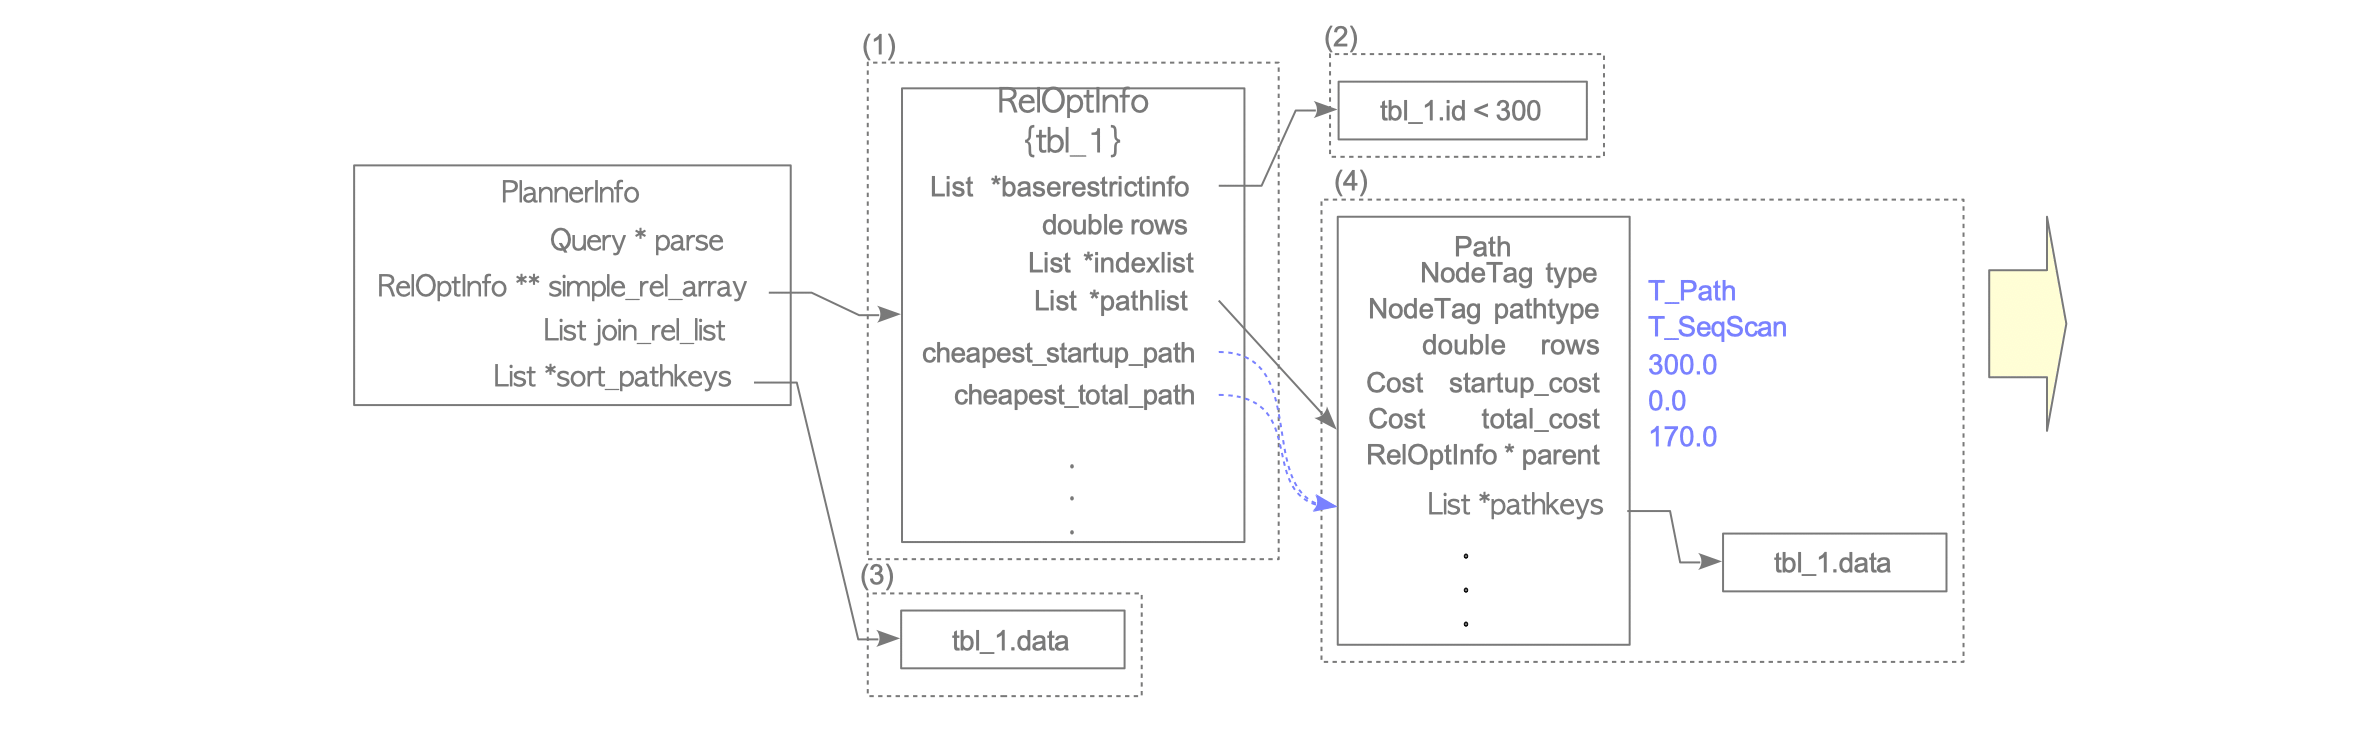

1. RelOptInfo 구조를 생성하고 PlannerInfo의 simple_rel_array에 저장.

2. RelOptInfo의 baserestrictinfo에 WHERE 절을 추가.
  - WHERE 절 '$id \lt 300$'은 initsplan.c에 정의된 distribution_restrictinfo_to_rels() 함수에 의해 baserestrictinfo에 추가됨.
  - 또한 RelOptInfo의 indexlist는 대상 테이블의 관련 인덱스가 없기 때문에 NULL. ’id<300’는 다음에 정의된distribution_restrictinfo_to_rels() 함수에 의해 baserestrictinfo에 추가됨.

3. planner.c 에 정의된 Standard_qp_callback() 함수를 통해 PlannerInfo의 sort_pathkeys에 정렬을 위한 경로키를 추가 .
  - Pathkey 는 경로의 정렬 순서를 나타내는 데이터 구조.
  - 이 예에서는 이 쿼리에 ORDER BY 절이 포함되어 있고 해당 열이 'data'이기 때문에 'data' 열이 sort_pathkeys에 경로 키로 추가됨.

4. 경로 구조를 생성하고, cost_seqscan 함수를 사용하여 순차적 스캔의 비용을 추정하고, 추정된 비용을 경로에 씀.
  - 그런 다음 pathnode.c 에 정의된 add_path() 함수를 사용하여 RelOptInfo에 경로를 추가 .
  - Path구조에는 cost_seqscan 함수 등으로 추정되는 시작 비용과 총 비용이 모두 포함 됨.

- 이 예에서는 대상 테이블의 인덱스가 없기 때문에 플래너는 순차 스캔 비용만 추정.
- 따라서 가장 저렴한 액세스 경로가 자동으로 결정됨.



**예제 1의 가장 저렴한 경로를 얻는 방법**

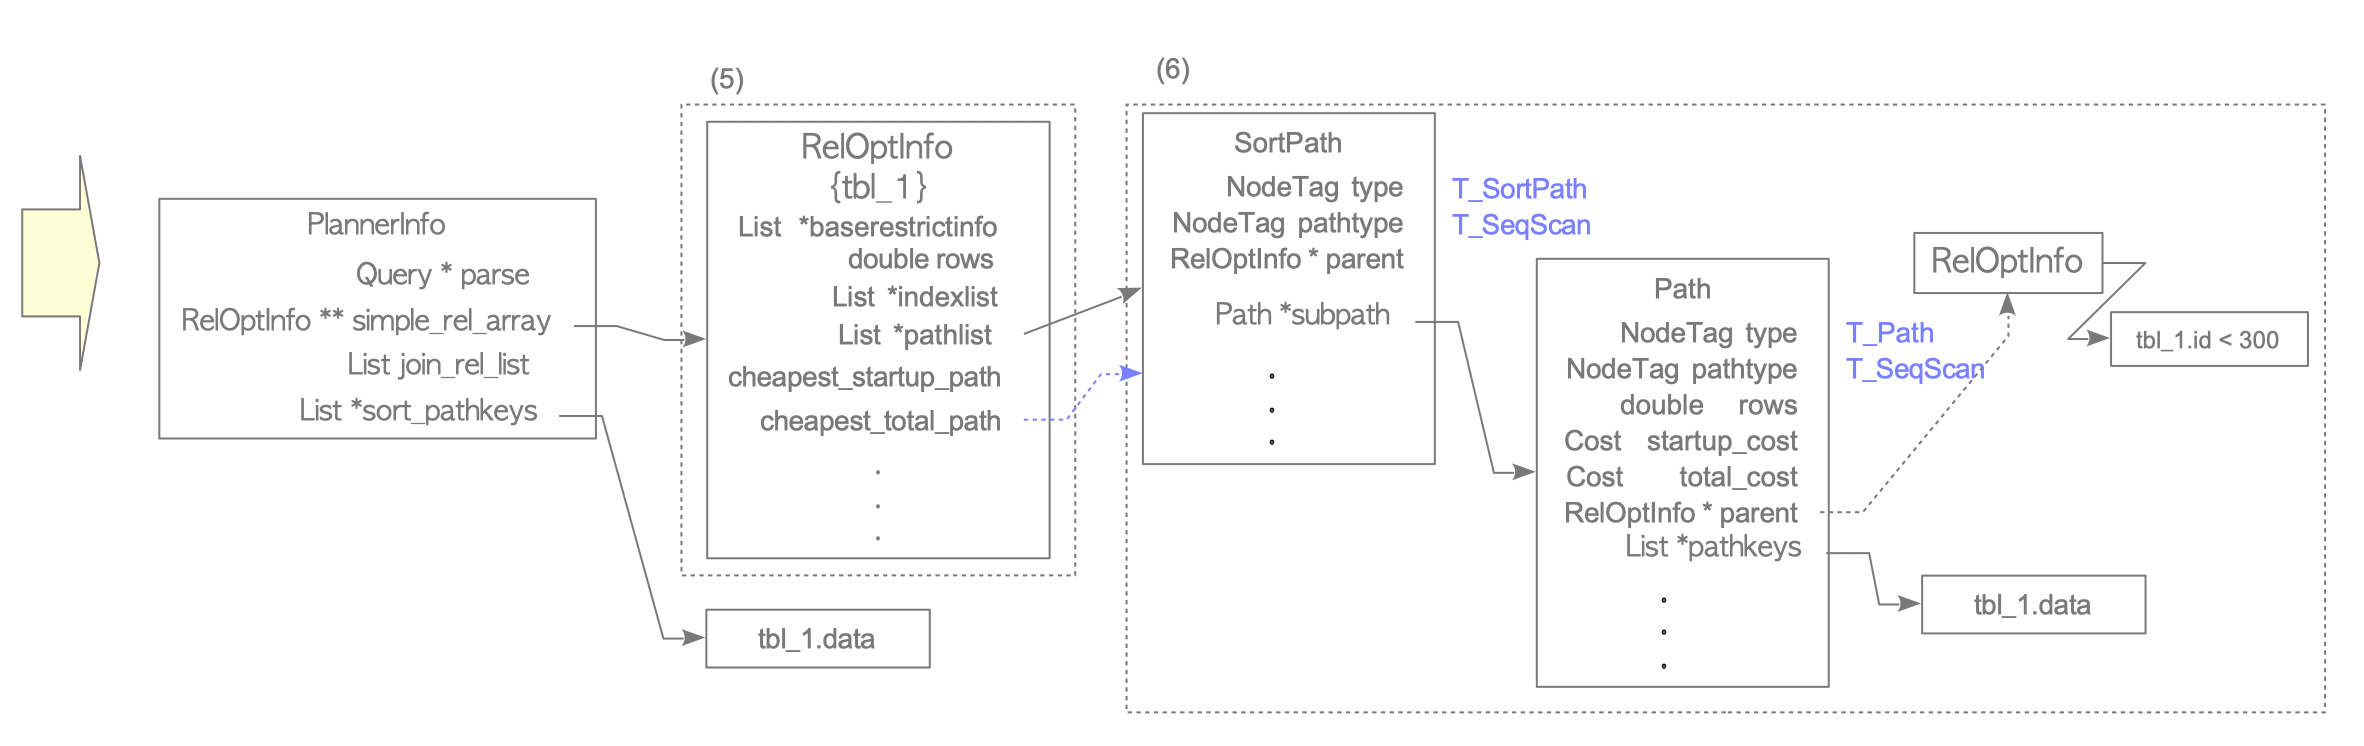

5. ORDER BY 절차를 처리하기 위해 새로운 RelOptInfo 구조를 생성.
  - 새로운 RelOptInfo에는 baserestrictinfo, 즉 WHERE 절의 정보가 없다는 점에 유의.

6. 정렬 경로를 생성하고 이를 새 RelOptInfo에 추가.
  - 그런 다음 순차 스캔 경로를 정렬 경로의 하위 경로에 연결.
  - 그만큼SortPath구조는 경로와 하위 경로라는 두 가지 경로 구조로 구성.
  - 경로는 정렬 작업 자체에 대한 정보를 저장하고 하위 경로는 가장 저렴한 경로를 저장.
  - 순차 스캔 경로의 '상위' 항목에는 baserestrictinfo에 WHERE 절을 저장하는 이전 RelOptInfo에 대한 링크가 포함 됨.
  - 즉 계획 트리 생성에서 플래너는 새로운 RelOptInfo에 baserestrictinfo가 없더라도 WHERE 절을 'Filter'로 포함하는 순차 스캔 노드를 생성할 수 있음.

**SortPath**


```
typedef struct SortPath
{
	Path	path;
	Path	*subpath;		/* path representing input source */
} SortPath;
```

- 여기에서 얻은 가장 저렴한 접근 경로를 기반으로 계획 트리가 생성

# **Example 2**

- 두 개의 인덱스가 있는 또 다른 단일 테이블 쿼리를 살펴 봄.
- 이 쿼리에는 WHERE 절이 포함되어 있음.



```
testdb=# \d tbl_2
     Table "public.tbl_2"
 Column |  Type   | Modifiers
--------+---------+-----------
 id     | integer | not null
 data   | integer |
Indexes:
    "tbl_2_pkey" PRIMARY KEY, btree (id)
    "tbl_2_data_idx" btree (data)

testdb=# SELECT * FROM tbl_2 WHERE id < 240;
```


**예제 2의 가장 저렴한 경로를 얻는 방법.**

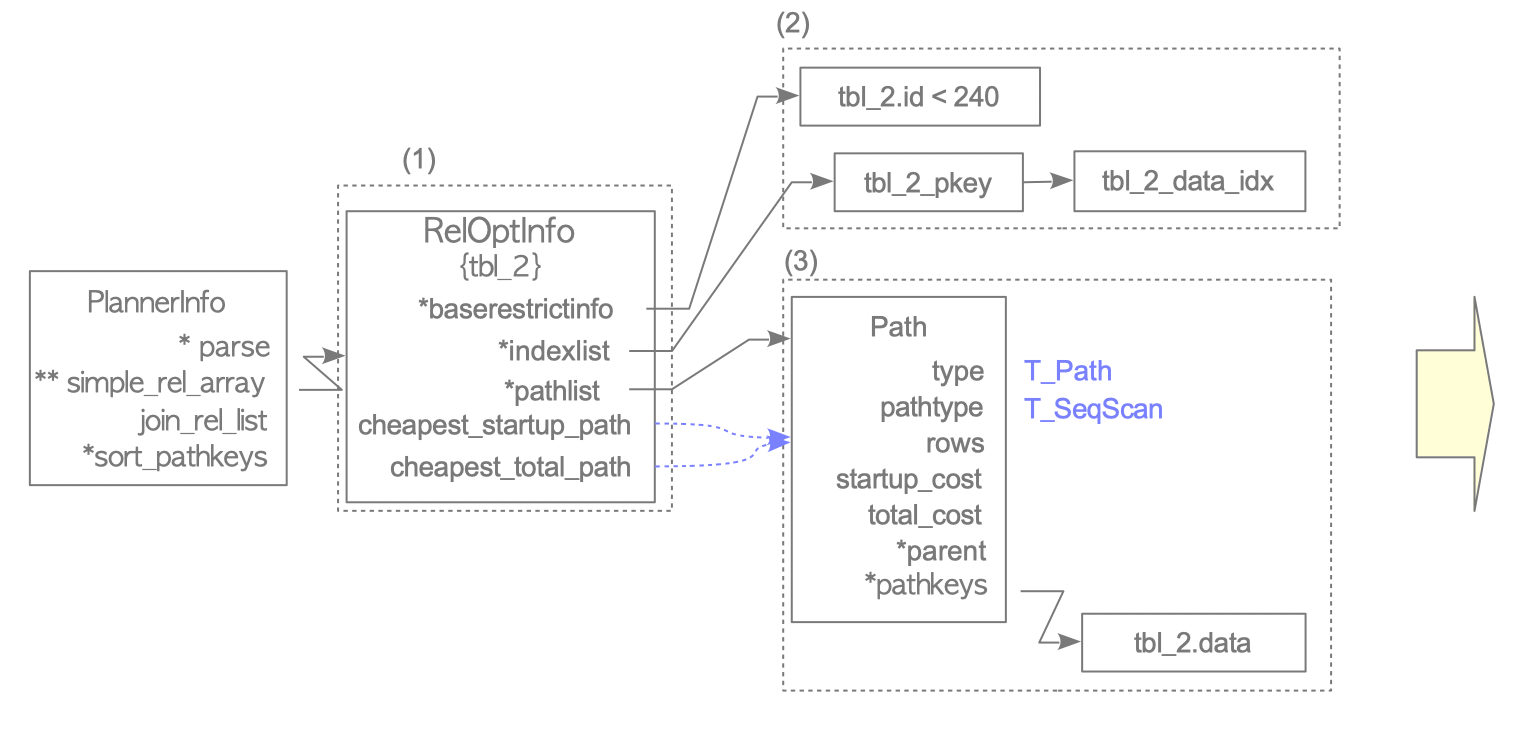

1. RelOptInfo 구조를 생성.

2. baserestrictinfo에 WHERE 절을 추가하고 indexlist에 대상 테이블의 인덱스를 추가.
  - 이 예에서는 WHERE 절 '$\text{id} \lt 240$'이 baserestrictinfo에 추가되고 두 ​​개의 인덱스 tbl_2_pkey 및 tbl_2_data_idx 가 RelOptInfo의 인덱스 목록에 추가됨. 'id<240'가 baserestrictinfo에 추가되고 두 ​​개의 인덱스가 추가됨.

3. 경로를 생성하고 순차 스캔 비용을 추정한 후 RelOptInfo의 경로 목록에 경로를 추가.



**예제 2의 가장 저렴한 경로를 얻는 방법**

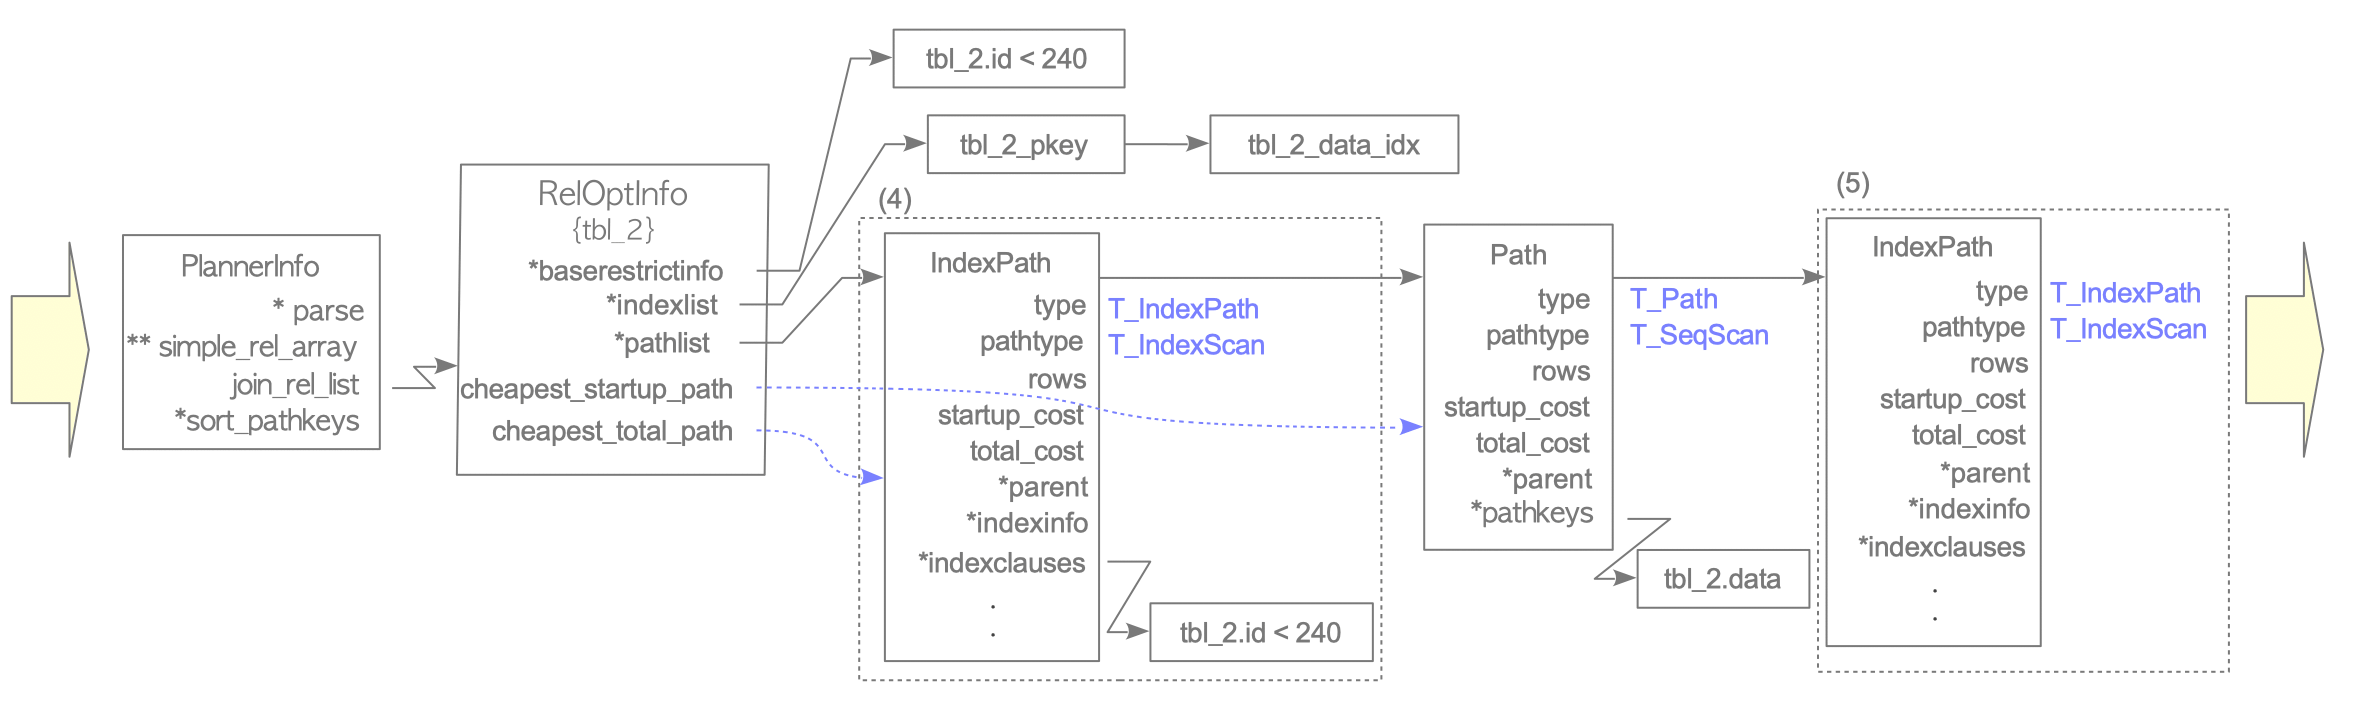

4. 생성IndexPath, 인덱스 스캔 비용을 추정하고 add_path() 함수를 사용하여 RelOptInfo의 경로 목록에 IndexPath를 추가.
  - 이 예에서는 tbl_2_pkey 와 tbl_2_data_idx라는 두 개의 인덱스가 있으므로 이 인덱스들을 순서대로 처리.
  - tbl_2_pkey 가 먼저 처리 됨.
  - tbl_2_pkey 에 대한 IndexPath가 생성되고 시작 비용과 총 비용이 모두 추정 됨.
  - 이 예에서 tbl_2_pkey는 'id' 컬럼과 관련된 인덱스이고, WHERE 절에는 'id' 컬럼이 포함 되어 있음.
  - 따라서 WHERE 절은 IndexPath의 indexclauses 에 저장됨.
  - 경로 목록에 액세스 경로를 추가할 때 add_path() 함수는 총 비용의 정렬 순서에 따라 경로를 추가한다는 점에 유의.
  - 이 예에서 이 인덱스 스캔의 총 비용은 순차적 총 비용보다 작음.
  - 따라서 이 인덱스 경로는 순차 스캔 경로 앞에 삽입 됨.

**IndexPath**



```
typedef struct IndexPath
{
	Path		path;
	IndexOptInfo *indexinfo;
	List	   *indexclauses;
	List	   *indexorderbys;
	List	   *indexorderbycols;
	ScanDirection indexscandir;
	Cost		indextotalcost;
	Selectivity indexselectivity;
} IndexPath;

/*
 * IndexOptInfo
 *		Per-index information for planning/optimization
 *
 *		indexkeys[], indexcollations[] each have ncolumns entries.
 *		opfamily[], and opcintype[]	each have nkeycolumns entries. They do
 *		not contain any information about included attributes.
 *
 *		sortopfamily[], reverse_sort[], and nulls_first[] have
 *		nkeycolumns entries, if the index is ordered; but if it is unordered,
 *		those pointers are NULL.
 *
 *		Zeroes in the indexkeys[] array indicate index columns that are
 *		expressions; there is one element in indexprs for each such column.
 *
 *		For an ordered index, reverse_sort[] and nulls_first[] describe the
 *		sort ordering of a forward indexscan; we can also consider a backward
 *		indexscan, which will generate the reverse ordering.
 *
 *		The indexprs and indpred expressions have been run through
 *		prepqual.c and eval_const_expressions() for ease of matching to
 *		WHERE clauses. indpred is in implicit-AND form.
 *
 *		indextlist is a TargetEntry list representing the index columns.
 *		It provides an equivalent base-relation Var for each simple column,
 *		and links to the matching indexprs element for each expression column.
 *
 *		While most of these fields are filled when the IndexOptInfo is created
 *		(by plancat.c), indrestrictinfo and predOK are set later, in
 *		check_index_predicates().
 */
#ifndef HAVE_INDEXOPTINFO_TYPEDEF
typedef struct IndexOptInfo IndexOptInfo;
#define HAVE_INDEXOPTINFO_TYPEDEF 1
#endif

struct IndexOptInfo
{
	pg_node_attr(no_copy_equal, no_read, no_query_jumble)

	NodeTag		type;

	/* OID of the index relation */
	Oid			indexoid;
	/* tablespace of index (not table) */
	Oid			reltablespace;
	/* back-link to index's table; don't print, else infinite recursion */
	RelOptInfo *rel pg_node_attr(read_write_ignore);

	/*
	 * index-size statistics (from pg_class and elsewhere)
	 */
	/* number of disk pages in index */
	BlockNumber pages;
	/* number of index tuples in index */
	Cardinality tuples;
	/* index tree height, or -1 if unknown */
	int			tree_height;

	/*
	 * index descriptor information
	 */
	/* number of columns in index */
	int			ncolumns;
	/* number of key columns in index */
	int			nkeycolumns;

	/*
	 * table column numbers of index's columns (both key and included
	 * columns), or 0 for expression columns
	 */
	int		   *indexkeys pg_node_attr(array_size(ncolumns));
	/* OIDs of collations of index columns */
	Oid		   *indexcollations pg_node_attr(array_size(nkeycolumns));
	/* OIDs of operator families for columns */
	Oid		   *opfamily pg_node_attr(array_size(nkeycolumns));
	/* OIDs of opclass declared input data types */
	Oid		   *opcintype pg_node_attr(array_size(nkeycolumns));
	/* OIDs of btree opfamilies, if orderable.  NULL if partitioned index */
	Oid		   *sortopfamily pg_node_attr(array_size(nkeycolumns));
	/* is sort order descending? or NULL if partitioned index */
	bool	   *reverse_sort pg_node_attr(array_size(nkeycolumns));
	/* do NULLs come first in the sort order? or NULL if partitioned index */
	bool	   *nulls_first pg_node_attr(array_size(nkeycolumns));
	/* opclass-specific options for columns */
	bytea	  **opclassoptions pg_node_attr(read_write_ignore);
	/* which index cols can be returned in an index-only scan? */
	bool	   *canreturn pg_node_attr(array_size(ncolumns));
	/* OID of the access method (in pg_am) */
	Oid			relam;

	/*
	 * expressions for non-simple index columns; redundant to print since we
	 * print indextlist
	 */
	List	   *indexprs pg_node_attr(read_write_ignore);
	/* predicate if a partial index, else NIL */
	List	   *indpred;

	/* targetlist representing index columns */
	List	   *indextlist;

	/*
	 * parent relation's baserestrictinfo list, less any conditions implied by
	 * the index's predicate (unless it's a target rel, see comments in
	 * check_index_predicates())
	 */
	List	   *indrestrictinfo;

	/* true if index predicate matches query */
	bool		predOK;
	/* true if a unique index */
	bool		unique;
	/* is uniqueness enforced immediately? */
	bool		immediate;
	/* true if index doesn't really exist */
	bool		hypothetical;

	/*
	 * Remaining fields are copied from the index AM's API struct
	 * (IndexAmRoutine).  These fields are not set for partitioned indexes.
	 */
	bool		amcanorderbyop;
	bool		amoptionalkey;
	bool		amsearcharray;
	bool		amsearchnulls;
	/* does AM have amgettuple interface? */
	bool		amhasgettuple;
	/* does AM have amgetbitmap interface? */
	bool		amhasgetbitmap;
	bool		amcanparallel;
	/* does AM have ammarkpos interface? */
	bool		amcanmarkpos;
	/* AM's cost estimator */
	/* Rather than include amapi.h here, we declare amcostestimate like this */
	void		(*amcostestimate) () pg_node_attr(read_write_ignore);
};
```

5. 또 다른 IndexPath를 생성하고, 다른 인덱스 스캔 비용을 추정하고, RelOptInfo의 경로 목록에 인덱스 경로를 추가.
  -  다음으로 tbl_2_data_idx에 대한 IndexPath가 생성되고 비용이 추정되며 이 IndexPath가 경로 목록에 추가 됨.
  - 이 예에는 tbl_2_data_idx 인덱스 와 관련된 WHERE 절이 없음
  - 따라서 인덱스 절은 NULL입니다.

- add_path() 함수가 항상 경로를 추가하지는 않음.


**예제 2의 가장 저렴한 경로를 얻는 방법.**

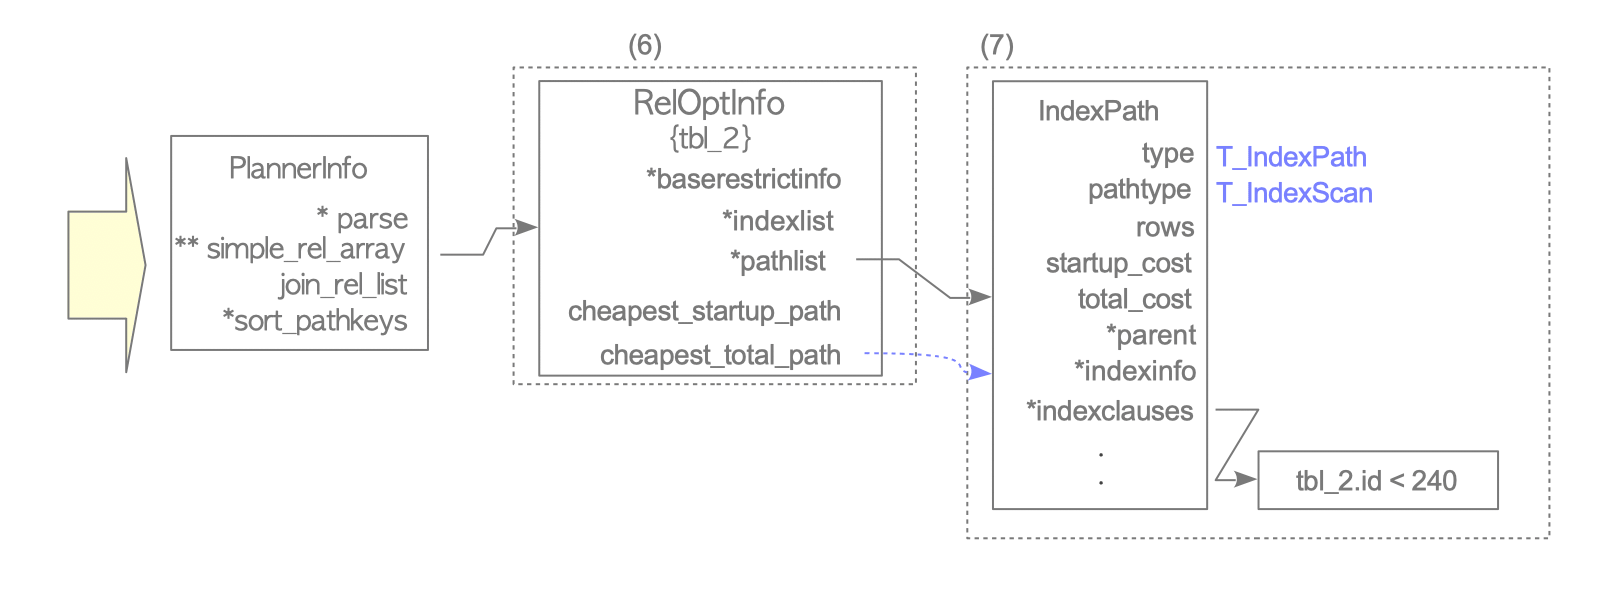

6. 새로운 RelOptInfo 구조를 생성.

7. 새로운 RelOptInfo의 경로 목록에 가장 저렴한 경로를 추가.
  - 이 예에서 가장 저렴한 경로는 tbl_2_pkey인덱스를 사용하는 인덱스 경로.  
  - 따라서 해당 경로가 새 RelOptInfo의 경로 목록에 추가 됨.

# **Creating a Plan Tree**

- 마지막 단계에서 플래너는 가장 저렴한 경로에서 계획 트리를 생성.

- 계획 트리의 루트는 다음과 같음.
- PlannedStmt plannodes.h 에 정의된 구조입니다 . 여기에는 19개의 필드가 포함되어 있지만 대표적인 필드는 다음과 같음.

- commandType은 SELECT, UPDATE 또는 INSERT와 같은 작업 유형을 저장.
- rtable은 rangeTable 항목을 저장.
- RelationOids는 이 쿼리에 대한 관련 테이블의 oid를 저장.
- planttree는 계획 노드로 구성된 계획 트리를 저장하며, 각 노드는 순차 스캔, 정렬 및 인덱스 스캔과 같은 특정 작업에 해당.

**PlannedStmt**


```
typedef struct PlannedStmt
{
	pg_node_attr(no_equal, no_query_jumble)

	NodeTag		type;

	CmdType		commandType;	/* select|insert|update|delete|merge|utility */

	uint64		queryId;		/* query identifier (copied from Query) */

	bool		hasReturning;	/* is it insert|update|delete RETURNING? */

	bool		hasModifyingCTE;	/* has insert|update|delete in WITH? */

	bool		canSetTag;		/* do I set the command result tag? */

	bool		transientPlan;	/* redo plan when TransactionXmin changes? */

	bool		dependsOnRole;	/* is plan specific to current role? */

	bool		parallelModeNeeded; /* parallel mode required to execute? */

	int			jitFlags;		/* which forms of JIT should be performed */

	struct Plan *planTree;		/* tree of Plan nodes */

	List	   *rtable;			/* list of RangeTblEntry nodes */

	List	   *permInfos;		/* list of RTEPermissionInfo nodes for rtable
								 * entries needing one */

	/* rtable indexes of target relations for INSERT/UPDATE/DELETE/MERGE */
	List	   *resultRelations;	/* integer list of RT indexes, or NIL */

	List	   *appendRelations;	/* list of AppendRelInfo nodes */

	List	   *subplans;		/* Plan trees for SubPlan expressions; note
								 * that some could be NULL */

	Bitmapset  *rewindPlanIDs;	/* indices of subplans that require REWIND */

	List	   *rowMarks;		/* a list of PlanRowMark's */

	List	   *relationOids;	/* OIDs of relations the plan depends on */

	List	   *invalItems;		/* other dependencies, as PlanInvalItems */

	List	   *paramExecTypes; /* type OIDs for PARAM_EXEC Params */

	Node	   *utilityStmt;	/* non-null if this is utility stmt */

	/* statement location in source string (copied from Query) */
	int			stmt_location;	/* start location, or -1 if unknown */
	int			stmt_len;		/* length in bytes; 0 means "rest of string" */
} PlannedStmt;
```

- 계획 트리는 다양한 계획 노드로 구성.
  -  그만큼PlanNode구조는 기본 노드이고 다른 노드에는 항상 이 구조가 포함.
  - 예를 들어, SeqScanNode순차 스캐닝을 위한 는 PlanNode와 정수 변수 'scanrelid'로 구성.
  -  PlanNode에는 14개의 필드가 포함되어 있음.

- 대표적인 7개 분야는 다음과 같음.

- start-up cost 와 total_cost는 이 노드에 해당하는 작업의 예상 비용.
- rows 은 플래너가 추정하는 스캔할 행 수.
- targetlist는 쿼리 트리에 포함된 대상 목록 항목을 저장.
- qual 은 qual 조건을 저장하는 목록.
- lefttree 및 righttree 는 하위 노드를 추가하기 위한 노드.

**Plan node**

```
/* ----------------
 *		Plan node
 *
 * All plan nodes "derive" from the Plan structure by having the
 * Plan structure as the first field.  This ensures that everything works
 * when nodes are cast to Plan's.  (node pointers are frequently cast to Plan*
 * when passed around generically in the executor)
 *
 * We never actually instantiate any Plan nodes; this is just the common
 * abstract superclass for all Plan-type nodes.
 * ----------------
 */
typedef struct Plan
{
	pg_node_attr(abstract, no_equal, no_query_jumble)

	NodeTag		type;

	/*
	 * estimated execution costs for plan (see costsize.c for more info)
	 */
	Cost		startup_cost;	/* cost expended before fetching any tuples */
	Cost		total_cost;		/* total cost (assuming all tuples fetched) */

	/*
	 * planner's estimate of result size of this plan step
	 */
	Cardinality plan_rows;		/* number of rows plan is expected to emit */
	int			plan_width;		/* average row width in bytes */

	/*
	 * information needed for parallel query
	 */
	bool		parallel_aware; /* engage parallel-aware logic? */
	bool		parallel_safe;	/* OK to use as part of parallel plan? */

	/*
	 * information needed for asynchronous execution
	 */
	bool		async_capable;	/* engage asynchronous-capable logic? */

	/*
	 * Common structural data for all Plan types.
	 */
	int			plan_node_id;	/* unique across entire final plan tree */
	List	   *targetlist;		/* target list to be computed at this node */
	List	   *qual;			/* implicitly-ANDed qual conditions */
	struct Plan *lefttree;		/* input plan tree(s) */
	struct Plan *righttree;
	List	   *initPlan;		/* Init Plan nodes (un-correlated expr
								 * subselects) */

	/*
	 * Information for management of parameter-change-driven rescanning
	 *
	 * extParam includes the paramIDs of all external PARAM_EXEC params
	 * affecting this plan node or its children.  setParam params from the
	 * node's initPlans are not included, but their extParams are.
	 *
	 * allParam includes all the extParam paramIDs, plus the IDs of local
	 * params that affect the node (i.e., the setParams of its initplans).
	 * These are _all_ the PARAM_EXEC params that affect this node.
	 */
	Bitmapset  *extParam;
	Bitmapset  *allParam;
} Plan;
```

**Scan nodes**

```
/*
 * ==========
 * Scan nodes
 *
 * Scan is an abstract type that all relation scan plan types inherit from.
 * ==========
 */
typedef struct Scan
{
	pg_node_attr(abstract)

	Plan		plan;
	Index		scanrelid;		/* relid is index into the range table */
} Scan;

/* ----------------
 *		sequential scan node
 * ----------------
 */
typedef struct SeqScan
{
	Scan		scan;
} SeqScan;
```

- 다음에서는 이전 하위 섹션의 예에 표시된 가장 저렴한 경로에서 생성되는 두 개의 계획 트리에 대해 설명


# **Example 1**

- 그림에 표시된 가장 저렴한 경로는 정렬 경로와 순차 스캔 경로로 구성된 트리.
- 루트 경로는 정렬 경로이고 하위 경로는 순차 검색 경로.

- 가장 저렴한 경로에서 거의 사소하게 플랜 트리를 생성할 수 있다는 점을 이해하면 쉬울 것.

- 이 예에서는SortNodePlannedStmt 구조의 플랜트 트리에 추가되고 SeqScanNode는 SortNode의 왼쪽 트리에 추가

**SortNode**


```

/* ----------------
 *		sort node
 * ----------------
 */
typedef struct Sort
{
	Plan		plan;

	/* number of sort-key columns */
	int			numCols;

	/* their indexes in the target list */
	AttrNumber *sortColIdx pg_node_attr(array_size(numCols));

	/* OIDs of operators to sort them by */
	Oid		   *sortOperators pg_node_attr(array_size(numCols));

	/* OIDs of collations */
	Oid		   *collations pg_node_attr(array_size(numCols));

	/* NULLS FIRST/LAST directions */
	bool	   *nullsFirst pg_node_attr(array_size(numCols));
} Sort;
```

**계획나무의 예.**

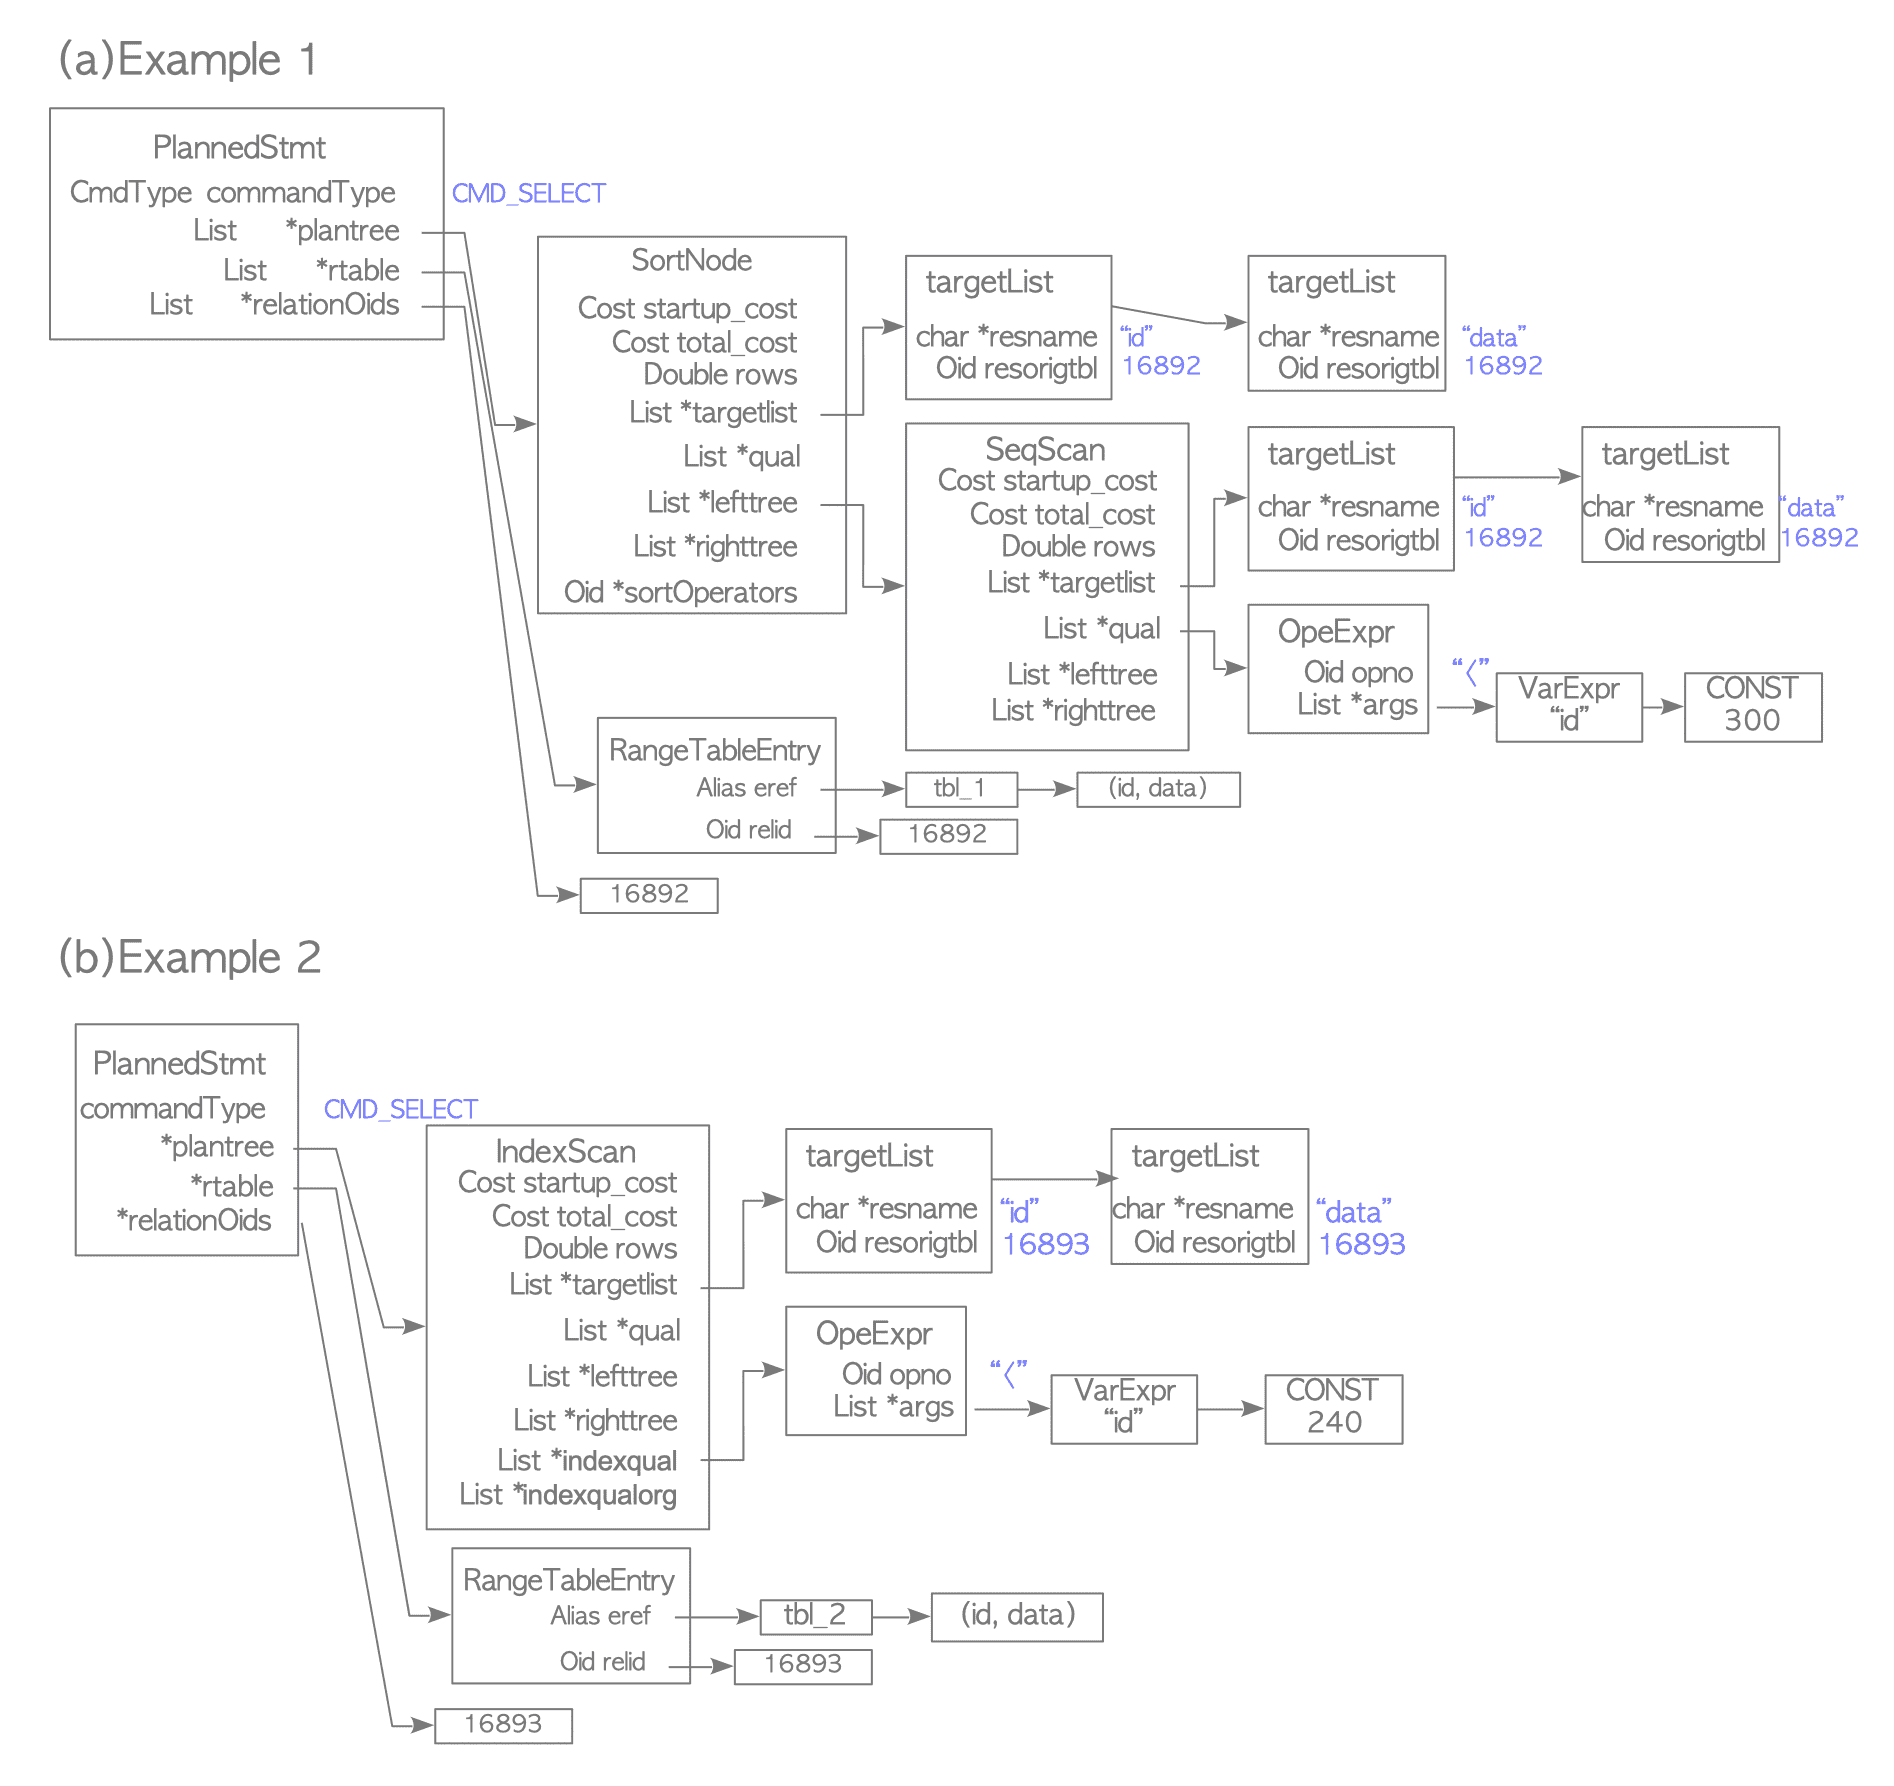

- SortNode에서 왼쪽 트리는 SeqScanNode를 가리킴.

- SeqScanNode에서 qual은 WHERE 절 '$\text{id} \lt 300$'을 보유. 'ID<300'


**Example 2**

- 그림에 표시된 가장 저렴한 경로는 인덱스 스캔 경로이므로 계획 트리는 다음과 같이 구성.

**IndexScanNode**



```
/* ----------------
 *		index scan node
 *
 * indexqualorig is an implicitly-ANDed list of index qual expressions, each
 * in the same form it appeared in the query WHERE condition.  Each should
 * be of the form (indexkey OP comparisonval) or (comparisonval OP indexkey).
 * The indexkey is a Var or expression referencing column(s) of the index's
 * base table.  The comparisonval might be any expression, but it won't use
 * any columns of the base table.  The expressions are ordered by index
 * column position (but items referencing the same index column can appear
 * in any order).  indexqualorig is used at runtime only if we have to recheck
 * a lossy indexqual.
 *
 * indexqual has the same form, but the expressions have been commuted if
 * necessary to put the indexkeys on the left, and the indexkeys are replaced
 * by Var nodes identifying the index columns (their varno is INDEX_VAR and
 * their varattno is the index column number).
 *
 * indexorderbyorig is similarly the original form of any ORDER BY expressions
 * that are being implemented by the index, while indexorderby is modified to
 * have index column Vars on the left-hand side.  Here, multiple expressions
 * must appear in exactly the ORDER BY order, and this is not necessarily the
 * index column order.  Only the expressions are provided, not the auxiliary
 * sort-order information from the ORDER BY SortGroupClauses; it's assumed
 * that the sort ordering is fully determinable from the top-level operators.
 * indexorderbyorig is used at runtime to recheck the ordering, if the index
 * cannot calculate an accurate ordering.  It is also needed for EXPLAIN.
 *
 * indexorderbyops is a list of the OIDs of the operators used to sort the
 * ORDER BY expressions.  This is used together with indexorderbyorig to
 * recheck ordering at run time.  (Note that indexorderby, indexorderbyorig,
 * and indexorderbyops are used for amcanorderbyop cases, not amcanorder.)
 *
 * indexorderdir specifies the scan ordering, for indexscans on amcanorder
 * indexes (for other indexes it should be "don't care").
 * ----------------
 */
typedef struct Scan
{
	pg_node_attr(abstract)

	Plan		plan;
	Index		scanrelid;		/* relid is index into the range table */
} Scan;

typedef struct IndexScan
{
	Scan		scan;
	Oid			indexid;		/* OID of index to scan */
	List	   *indexqual;		/* list of index quals (usually OpExprs) */
	List	   *indexqualorig;	/* the same in original form */
	List	   *indexorderby;	/* list of index ORDER BY exprs */
	List	   *indexorderbyorig;	/* the same in original form */
	List	   *indexorderbyops;	/* OIDs of sort ops for ORDER BY exprs */
	ScanDirection indexorderdir;	/* forward or backward or don't care */
} IndexScan;
```

- 이 예에서 WHERE 절 '$\text{id} \lt 240$'은 액세스 조건자이므로 IndexScanNode의 indexqual에 저장. 'ID<240 '는 액세스 조건자이므로 IndexScanNode의 indexqual에 저장.